## Hyper parameter tuning and other exercises
- E01: Tune the hyperparameters of the training to beat my best validation loss of 2.2
- E02: I was not careful with the intialization of the network in this video. 
     - (1) What is the loss you'd get if the predicted probabilities at initialization were perfectly uniform? What loss do we achieve? 
     - (2) Can you tune the initialization to get a starting loss that is much more similar to (1)?
- E03: Read the Bengio et al 2003 paper (link above), implement and try any idea from the paper. Did it work?

In [44]:
import math
import random

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

%matplotlib inline

In [45]:
words = open('names.txt', 'r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [46]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [195]:
def build_dataset(words_list, block_size=3):
    X, Y = [], []

    for w in words_list:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    
    return X, Y

def split_data(X, Y, ratios=(0.8, 0.1, 0.1)):
    n1 = int(ratios[0] * len(words))
    n2 = int((ratios[0] + ratios[1]) * len(words))

    Xtr, Ytr = X[:n1], Y[:n1]
    Xdev, Ydev = X[n1:n2], Y[n1:n2]
    Xte, Yte = X[n2:], Y[n2:]

    return Xtr, Ytr, Xdev, Ydev, Xte, Yte

In [235]:
class MyNeuralNetwork:
    def __init__(self, block_size=3, embedding_size=2, hidden_size=100):
        self.C = torch.randn(27, embedding_size, requires_grad=True)  # Set requires_grad=True
        self.W1 = torch.randn(block_size * embedding_size, hidden_size, requires_grad=True)  # Set requires_grad=True
        self.b1 = torch.randn(hidden_size, requires_grad=True)  # Set requires_grad=True
        self.W2 = torch.randn(hidden_size, 27, requires_grad=True)  # Set requires_grad=True
        self.b2 = torch.randn(27, requires_grad=True)  # Set requires_grad=True
        self.parameters = [self.C, self.W1, self.b1, self.W2, self.b2]

    def forward(self, X):
        emb = self.C[X]
        h = torch.tanh(emb.view(-1, emb.size(-1) * emb.size(-2)) @ self.W1 + self.b1)
        logits = h @ self.W2 + self.b2
        return logits

    def validate(self, X, Y):
        with torch.no_grad():
            logits = self.forward(X)
            loss = F.cross_entropy(logits, Y)
        return loss.item()

    def train(self, X, Y, batch_size=32, learning_rate=0.01, num_epochs=10000):
        train_loss = []

        for epoch in range(num_epochs):
            ix = torch.randint(0, X.shape[0], (batch_size, ))
            logits = self.forward(X[ix])
            loss = F.cross_entropy(logits, Y[ix])

            for p in self.parameters:
                p.grad = None

            loss.backward()

            if isinstance(learning_rate, float):
                for p in self.parameters:
                    p.data += -learning_rate * p.grad
                if epoch % 100 == 0:
                    train_loss.append(loss.item())
            elif isinstance(learning_rate, list):
                lrs = []
                for p in self.parameters:
                    p.data += -learning_rate[epoch] * p.grad
                lrs.append(learning_rate[epoch])
                train_loss.append(loss.item())
                # print(f'Epoch {epoch}, Training Loss: {loss.item()}, Validation Loss: {val_loss[-1]}')
        return train_loss

In [245]:
def visualize_loss(train_loss, learning_rates=None):
    if learning_rates is None:
        plt.plot(train_loss, label='Training Loss')
        # plt.plot(val_loss, label='Validation Loss')
        plt.xlabel('Epoch (100x)')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
    else:
        plt.plot(learning_rates, train_loss, label='Training Loss')
        # plt.plot(learning_rates, val_loss, label='Validation Loss')
        # plt.xticks(learning_rates)
        plt.xlabel('Learning Rate')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

### Execise 1: Hyperparameter Tuning

In [250]:
X, Y = build_dataset(words, block_size=3)
Xtr, Ytr, Xdev, Ydev, Xte, Yte = split_data(X, Y)

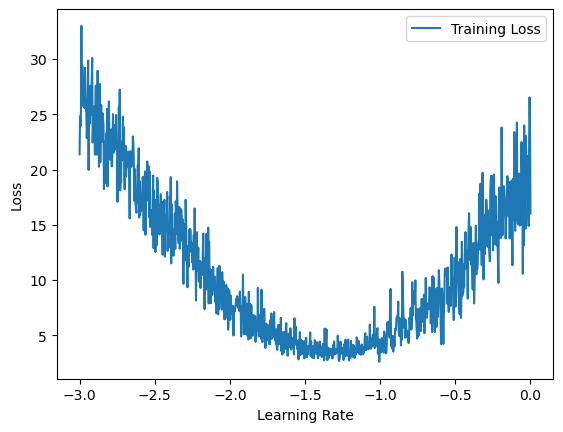

In [251]:
net = MyNeuralNetwork(block_size=3, hidden_size=300)
lre = np.linspace(-3, 0, 1000)
lrs = list(10**lre)

train_loss = net.train(Xtr, Ytr, learning_rate=lrs, num_epochs=1000)
visualize_loss(train_loss, learning_rates=lre)

In [262]:
train_loss = net.train(Xtr, Ytr, learning_rate=10**-2.0, num_epochs=30000)

In [263]:
val_loss = net.validate(Xdev, Ydev)
val_loss

2.240414619445801

In [270]:
# Finding the best learning rate for block_size between 3 and 11
# fig, axs = plt.subplots(2, 4, figsize=(20, 7))
# axs = axs.flatten()
for i in np.arange(3, 11):
    X, Y = build_dataset(words, block_size=i)
    Xtr, Ytr, Xdev, Ydev, Xte, Yte = split_data(X, Y)

    net = MyNeuralNetwork(block_size=i, hidden_size=300)
    lre = np.linspace(-3, 0, 30000)
    lrs = list(10**lre)

    train_loss = net.train(Xtr, Ytr, learning_rate=10**-1.5, num_epochs=30000)
    val_loss = net.validate(Xdev, Ydev)
    print(f'Block Size: {i} | Val Loss:{val_loss:.4f}')
    # axs[i-3].plot(train_loss, label='Training_loss')
    # axs[i-3].set_title(f'Block Size: {i} | Avg Val Loss: {val_loss:.2f}')
    # axs[i-3].set_xticks()


Block Size: 3 | Val Loss:2.3668
Block Size: 4 | Val Loss:2.2717
Block Size: 5 | Val Loss:2.2490
Block Size: 6 | Val Loss:2.3460
Block Size: 7 | Val Loss:2.3664
Block Size: 8 | Val Loss:2.4170
Block Size: 9 | Val Loss:2.3962
Block Size: 10 | Val Loss:2.2977


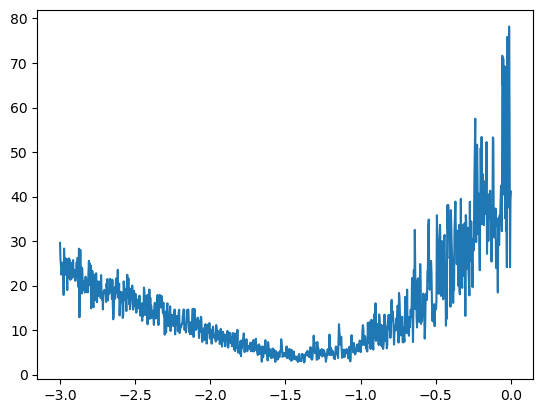

In [328]:
X, Y = build_dataset(words, block_size=10)
Xtr, Ytr, Xdev, Ydev, Xte, Yte = split_data(X, Y)

net = MyNeuralNetwork(block_size=10, embedding_size=2, hidden_size=300)

lre = np.linspace(-3, 0, 1000)
lrs = list(10**lre)

train_loss = net.train(Xtr, Ytr, learning_rate=lrs, num_epochs=1000)
val_loss_ = net.validate(Xte, Yte)

plt.plot(lre, train_loss, label='Training_loss')

In [329]:
net = MyNeuralNetwork(block_size=10, embedding_size=2, hidden_size=300)

In [338]:
train_loss = net.train(Xtr, Ytr, learning_rate=0.01, num_epochs=50000)

In [339]:
val_loss = net.validate(Xdev, Ydev)
val_loss

2.228931188583374

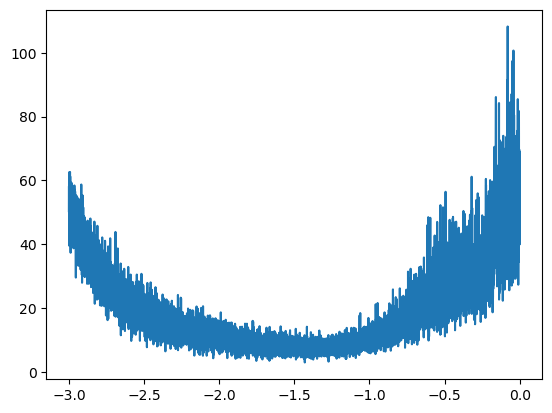

In [558]:
X, Y = build_dataset(words, block_size=6)
Xtr, Ytr, Xdev, Ydev, Xte, Yte = split_data(X, Y)

net = MyNeuralNetwork(block_size=6, embedding_size=10, hidden_size=900)

lre = np.linspace(-3, 0, 10000)
lrs = list(10**lre)

train_loss = net.train(Xtr, Ytr, learning_rate=lrs, num_epochs=10000)
val_loss_ = net.validate(Xte, Yte)

plt.plot(lre, train_loss, label='Training_loss')

In [589]:
net = MyNeuralNetwork(block_size=6, embedding_size=10, hidden_size=900)

In [591]:
# block_size=6, embedding_size=10, hidden_size=900
for i in range(10):
    train_loss = net.train(Xtr, Ytr, batch_size=300, learning_rate=0.001, num_epochs=50000)
    val_loss = net.validate(Xdev, Ydev)
    print(f'Avg Training Loss: {np.mean(train_loss):.4f}, Validation Loss: {val_loss:.4f}')

Avg Training Loss: 1.4006, Validation Loss: 2.8435
Avg Training Loss: 1.3905, Validation Loss: 2.8529
Avg Training Loss: 1.3960, Validation Loss: 2.8639
Avg Training Loss: 1.3896, Validation Loss: 2.8725
Avg Training Loss: 1.3831, Validation Loss: 2.8833
Avg Training Loss: 1.3872, Validation Loss: 2.8961


KeyboardInterrupt: 

In [554]:
# block_size=5, embedding_size=6, hidden_size=300
for i in range(5):
    train_loss = net.train(Xtr, Ytr, learning_rate=0.0003, num_epochs=50000)
    val_loss = net.validate(Xdev, Ydev)
    print(val_loss)

2.156205892562866
2.1550285816192627
2.1571428775787354
2.154038667678833
2.1527979373931885


In [532]:
# block_size=5, embedding_size=6, hidden_size=700
for i in range(5):
    train_loss = net.train(Xtr, Ytr, learning_rate=0.0001, num_epochs=50000)
    val_loss = net.validate(Xdev, Ydev)
    print(val_loss)

2.221719741821289
2.219860792160034
2.2196905612945557
2.2182271480560303
2.219137191772461


In [528]:
# block_size=5, embedding_size=5, hidden_size=700
for i in range(5):
    train_loss = net.train(Xtr, Ytr, learning_rate=0.0001, num_epochs=50000)
    val_loss = net.validate(Xdev, Ydev)
    print(val_loss)

2.1846907138824463
2.1845078468322754
2.1853079795837402
2.183605432510376
2.184354066848755


In [523]:
# block_size=5, embedding_size=5, hidden_size=600
for i in range(5):
    train_loss = net.train(Xtr, Ytr, learning_rate=0.0001, num_epochs=50000)
    val_loss = net.validate(Xdev, Ydev)
    print(val_loss)

2.1218976974487305
2.1229779720306396
2.123035430908203
2.121833324432373
2.123595952987671


In [508]:
# block_size=3, embedding_size=5, hidden_size=600
for i in range(5):
    train_loss = net.train(Xtr, Ytr, learning_rate=0.003, num_epochs=50000)
    val_loss = net.validate(Xdev, Ydev)
    print(val_loss)

2.5665485858917236
2.5761430263519287
2.5712521076202393
2.5835065841674805
2.5846621990203857


In [565]:
samples = torch.tensor([[4, 3, 2], [1, 2, 6]])

### Exercise 2: Uniform Probabilities

In [599]:
X, Y = build_dataset(words, block_size=6)
Xtr, Ytr, Xdev, Ydev, Xte, Yte = split_data(X, Y)
Xtr.shape, Ytr.shape

(torch.Size([25626, 6]), torch.Size([25626]))

In [603]:
loss = F.cross_entropy(torch.ones(25626, 27)/27, Ytr)
loss.item()

3.295837163925171

In [ ]:
class MyNeuralNetwork:
    def __init__(self, block_size=3, embedding_size=2, hidden_size=100):
        self.C = torch.randn(27, embedding_size, requires_grad=True)  # Set requires_grad=True
        self.W1 = torch.randn(block_size * embedding_size, hidden_size, requires_grad=True)  # Set requires_grad=True
        self.b1 = torch.randn(hidden_size, requires_grad=True)  # Set requires_grad=True
        self.W2 = torch.randn(hidden_size, 27, requires_grad=True)  # Set requires_grad=True
        self.b2 = torch.randn(27, requires_grad=True)  # Set requires_grad=True
        self.parameters = [self.C, self.W1, self.b1, self.W2, self.b2]

    def forward(self, X):
        emb = self.C[X]
        h = torch.tanh(emb.view(-1, emb.size(-1) * emb.size(-2)) @ self.W1 + self.b1)
        logits = h @ self.W2 + self.b2
        return logits

    def validate(self, X, Y):
        with torch.no_grad():
            logits = self.forward(X)
            loss = F.cross_entropy(logits, Y)
        return loss.item()

    def train(self, X, Y, batch_size=32, learning_rate=0.01, num_epochs=10000):
        train_loss = []

        for epoch in range(num_epochs):
            ix = torch.randint(0, X.shape[0], (batch_size, ))
            logits = self.forward(X[ix])
            loss = F.cross_entropy(logits, Y[ix])

            for p in self.parameters:
                p.grad = None

            loss.backward()

            if isinstance(learning_rate, float):
                for p in self.parameters:
                    p.data += -learning_rate * p.grad
                if epoch % 100 == 0:
                    train_loss.append(loss.item())
            elif isinstance(learning_rate, list):
                lrs = []
                for p in self.parameters:
                    p.data += -learning_rate[epoch] * p.grad
                lrs.append(learning_rate[epoch])
                train_loss.append(loss.item())
                # print(f'Epoch {epoch}, Training Loss: {loss.item()}, Validation Loss: {val_loss[-1]}')
        return train_loss